### Data Preprocessing and Vanilla Logistic Regression with L2-Regularizer (or elastic net?)

In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import sklearn.preprocessing as preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, confusion_matrix

from sklearn.linear_model import LogisticRegressionCV

from matplotlib import pyplot as plt

In [2]:
## Functions

# Data import routine
# 'train_file' and 'test_file' are filenames relative to the notebook
# 'feature_list' matches .csv files for the Adult dataset. See usage for exact list.
def import_data(train_file, test_file, feature_list):
    # Read files
    train_data = pd.read_csv(train_file,
                             names = feature_list,
                             sep = r'\s*,\s*',
                             engine = 'python',
                             na_values = "?")
    test_data = pd.read_csv(test_file,
                            names = feature_list,
                            sep = r'\s*,\s*',
                            engine = 'python',
                            na_values = "?")
    
    # Return raw dataframes
    return train_data, test_data

# Data pre-processing routine
# 'raw_data' is the entire data (all features + classes)
# 'S_id' should be a valid string with the name of the protected feature
# Examples of valid 'S_id': False, 'Sex_Female', 'Race_Non-White'
# TODO: generalize list of fully dropped features
# TODO: generalize list of compressed features
# TODO: generalize list of post-encoding dropped features
def split_protected_variable(raw_data, S_id):
    # Drop completely irrelevant features
    # "fnlwgt" is a control feature related to how data was sampled
    # "Education" is the discrete version of "Education-Num"
    raw_data = raw_data.drop(["fnlwgt", "Education"], axis = 1)
    
    # Compress country as US / non-US
    raw_data['Country'][raw_data['Country'].str.contains('United-States') == False] = 'Non-US'
    # Compress workclass as Private / non-Private
    raw_data['Workclass'][raw_data['Workclass'].str.contains('Private') == False] = 'Non-Private'
    # Compress race as White / non-White
    raw_data['Race'][raw_data['Race'].str.contains('White') == False] = 'Non-White'
    # Drop relationship
    raw_data = raw_data.drop(['Relationship'], axis = 1)
    
    # Encode categorical features with dummy variables
    encoded_data = pd.get_dummies(raw_data,
                                  columns = ["Workclass", "Race", "Marital Status",
                                             "Occupation", "Sex",
                                             "Country", "Target"],
                                  prefix = ["Workclass", "Race", "Marital_status",
                                              "Occupation", "Sex",
                                              "Country", "Target"])
    
    # Drop the dummy feature with the most frequent value for colinearity reasons
    # This takes care of '?'/NaN by implictly replacing them with the most common entry
    encoded_data = encoded_data.drop(["Workclass_Private", "Race_White",
                                      "Marital_status_Married-civ-spouse", "Occupation_Prof-specialty",
                                      "Sex_Male", "Country_United-States", "Target_<=50K"],
                                     axis = 1)
    
    # Centering and normalizing continuous columns entries
    numerical_features = ["Age", "Education-Num", "Capital Gain", "Capital Loss", "Hours per week"]
    for featureName in numerical_features:
        encoded_data[featureName] = (encoded_data[featureName] - np.mean(encoded_data[featureName], axis=0)) / np.std(encoded_data[featureName], axis=0)
        
    # Return triple (X, S, y). Return only (X, y) is 'S_id' is void
    if not S_id:
        X = encoded_data.drop(['Target_>50K'], axis = 1)
        S = False
        y = encoded_data['Target_>50K']
    else:
        X = encoded_data.drop(['Target_>50K'], axis = 1)
        S = encoded_data[S_id]
        y = encoded_data['Target_>50K']

    return X, S, y

# Confusion matrix plot routine
# This function prints and plots the confusion matrix
# Normalization can be applied by setting `normalize=True`
# TODO: Add online reference
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Encode the categorical features as numbers
# Display feature cross-correlation plot
def plot_feature_correlation(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
            
    fig = plt.figure(figsize = (30, 10))
    palette = sns.color_palette("RdBu", n_colors=100)
    palette.reverse()
    
    # sns.heatmap(result.corr(), square=True, cmap="seismic")
    sns.heatmap(result.corr(), square=True, cmap=palette, center=0, vmin=-1, vmax=1)
    plt.show()

In [3]:
# Read from .csv files
train_file = '../data/adult_train.csv'
test_file  = '../data/adult_test.csv'
feature_list = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
                "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
                "Hours per week", "Country", "Target"]

# Read data
train_data, test_data = import_data(train_file, test_file, feature_list)

# Comments:
# 1. We can compress countries as US / non-US
# 2. We can compress race as White / non-White or White / Black / Other
# 3. We can compress workclass as Private / non-Private
# 3. 'Marital Status' and 'Relationship' appear to have significant overlap
# 4. We can guess that 'Occupation' and 'Education' have a big impact on the target
# We will use them to pre-determine a gender/race/other bias in the data

# Extract X and y - no protected variable
S_id = 'Race_Non-White' # 'Sex_Female' or 'Race_Non-White' are valid options
X_train, S_train, y_train = split_protected_variable(train_data, S_id)
X_test, S_test, y_test = split_protected_variable(test_data, S_id)

C:\Users\ma56473\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ma56473\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ma56473\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of missing entries in target column, train data: 0
Number of missing entries in target column, test data: 0
If there would have been missing entries in the target column, we'd have removed the entire datapoints.


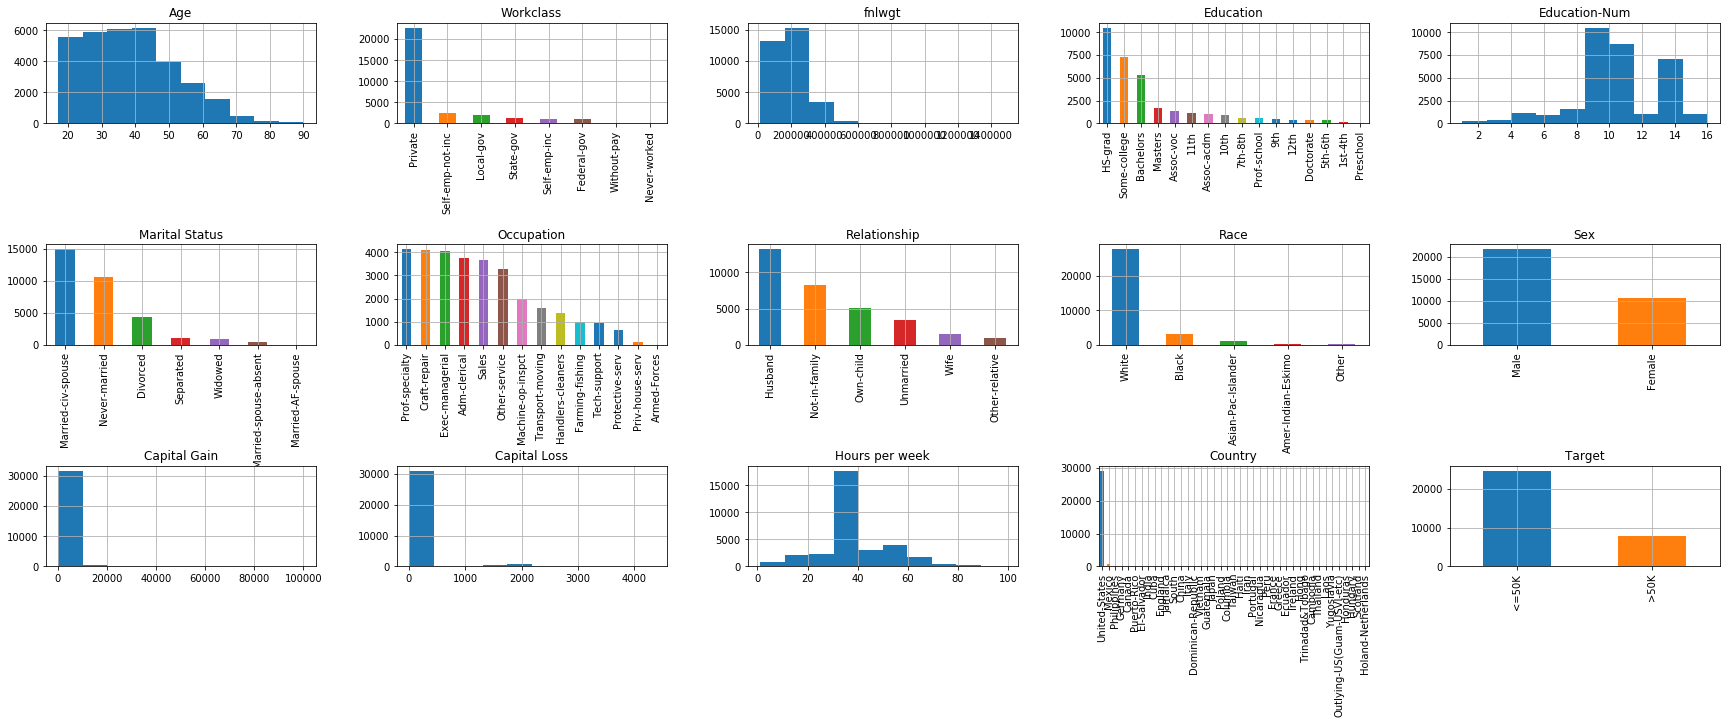

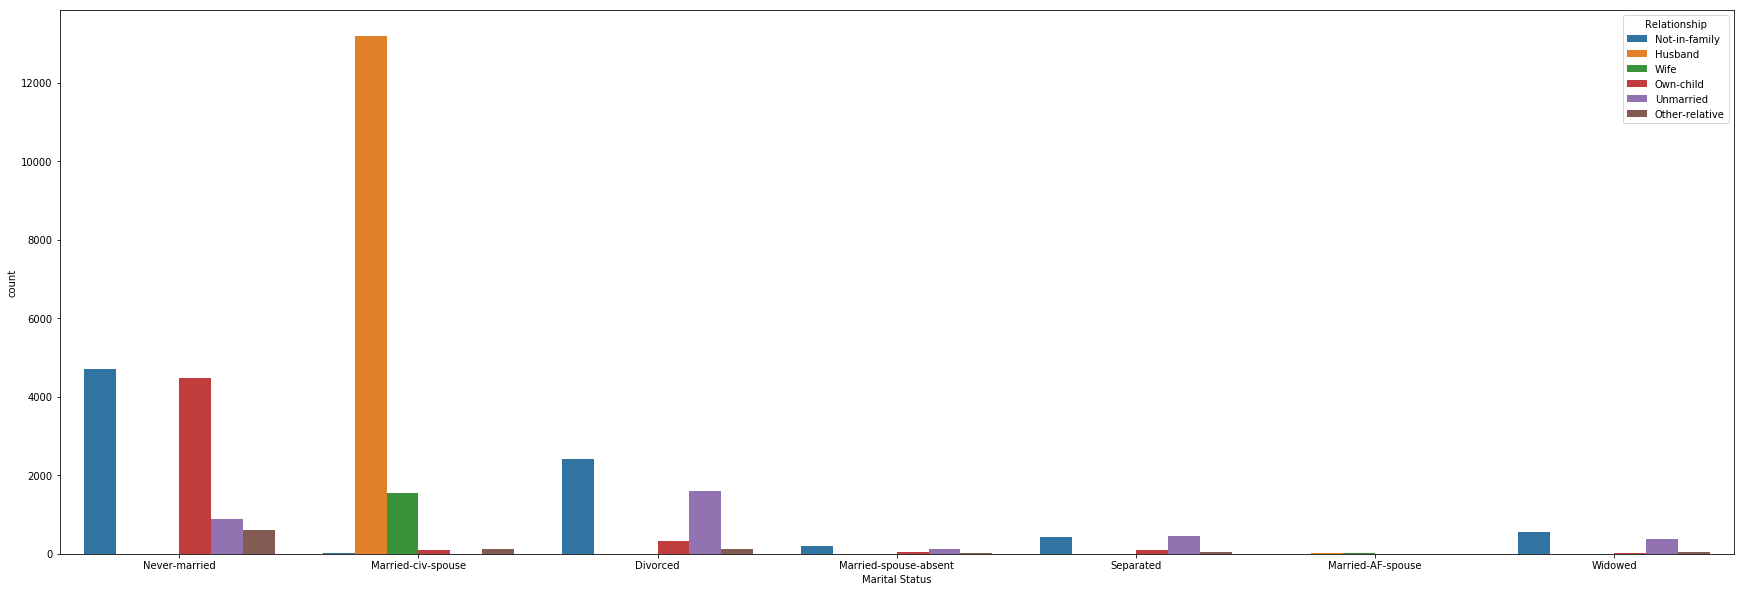

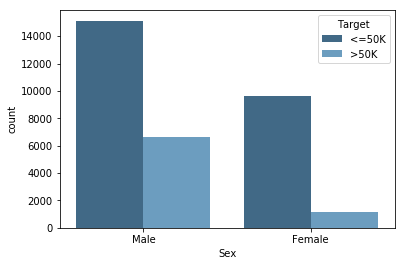

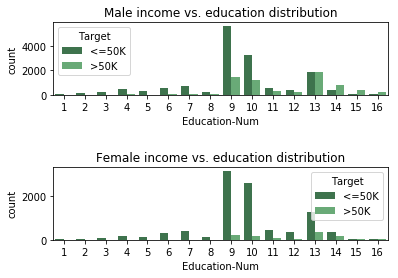

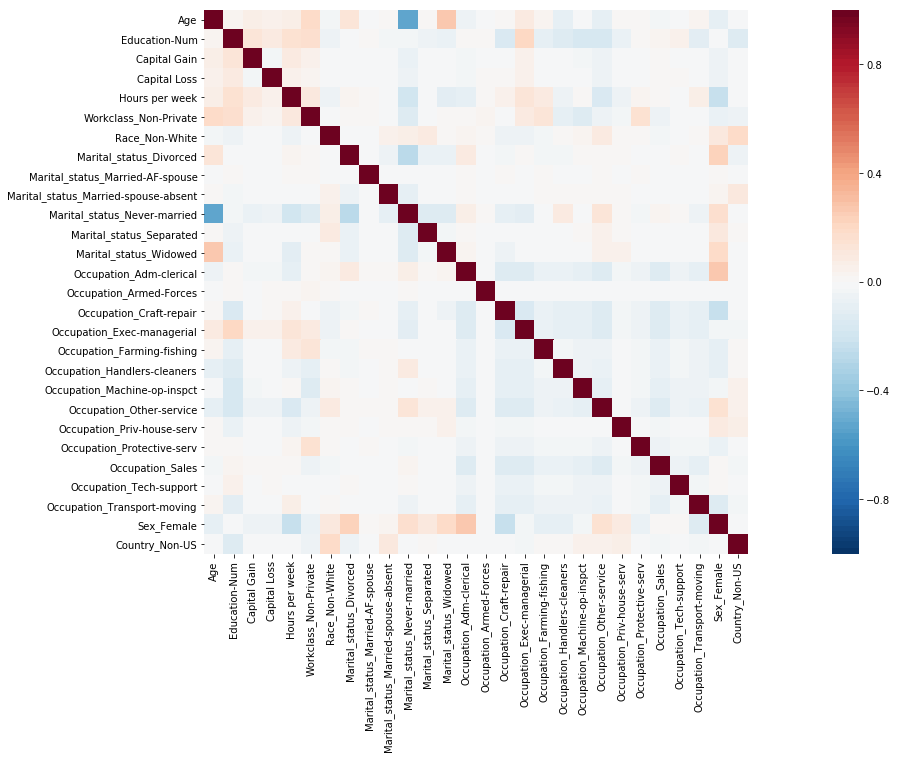

In [4]:
## Data visualization

# Sanity check for missing values in target column.
check_target_nan_train = train_data['Target']
check_target_nan_test  = test_data['Target']
print('Number of missing entries in target column, train data:', len(check_target_nan_train) - check_target_nan_train.count())
print('Number of missing entries in target column, test data:', len(check_target_nan_test) - check_target_nan_test.count())
print('If there would have been missing entries in the target column, we\'d have removed the entire datapoints.')

# Plot 1-D histograms for all features
fig = plt.figure(figsize = (30, 10))
numRows = 3;
numCols = 5;

for i, col in enumerate(train_data.columns):
    ax = fig.add_subplot(numRows, numCols, i+1)
    ax.set_title(col)
    if train_data.dtypes[col] == np.object:
        train_data[col].value_counts().plot(kind = 'bar', axes = ax)
        plt.grid()
    else:
        train_data[col].hist(axes = ax)
        
plt.subplots_adjust(hspace = 1.2, wspace = 0.3)

# Plot cross-histograms of 'Marital Status' and 'Relationship' to ballpark correlation
# This is used as justification for dropping 'Relationship'
plt.figure(figsize = (30, 10))
sns.countplot(x = 'Marital Status', hue = 'Relationship', data = train_data)

# Anticipating gender/race bias in the data
# Overall bias w.r.t. gender (TODO: race)
fig = plt.figure()
sns.countplot(x = "Sex", hue = "Target", data = train_data, palette = "Blues_d")

# Gender-education bias w.r.t. income
male_data = train_data[train_data["Sex"] == 'Male']
female_data = train_data[train_data["Sex"] == 'Female']

fig = plt.figure()
# Male plot
fig.add_subplot(2, 1, 1)
sns.countplot(x = "Education-Num", hue = "Target", data = male_data, palette="Greens_d")
plt.title("Male income vs. education distribution")
# Female plot
fig.add_subplot(2, 1, 2)
sns.countplot(x = "Education-Num", hue = "Target", data = female_data, palette="Greens_d")
plt.title("Female income vs. education distribution")

plt.subplots_adjust(hspace = 1)

# Calculate the correlation and plot it; before preprocessing
plot_feature_correlation(X_train)

Best auc_roc: 0.9093105537117759
Confusion matrix, without normalization
[[11589  1611]
 [  846  2235]]
Best auc_roc: 0.9092842385740705
Regression coefficients: [[ 0.32316178  0.78968652  2.33773816  0.26486716  0.39459482 -0.06526329
  -0.17193155 -2.12912431  0.69475667 -2.17862148 -2.65419574 -2.24021601
  -2.17864444 -0.16315006 -0.71001781 -0.22881506  0.4998354  -1.54413724
  -0.93213981 -0.52592766 -1.06767463 -4.42674041  0.2335735  -0.02911635
   0.38960853 -0.38631624 -0.15012179 -0.15739327]]


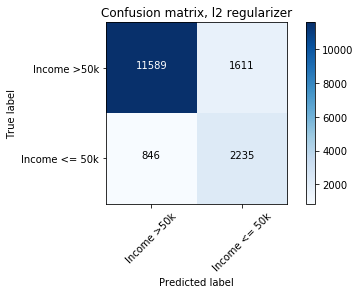

In [5]:
# Run vanilla logistic regression, L2 regularization
logreg = LogisticRegressionCV(Cs = list(np.power(10.0, np.arange(-10, 10))),
                              penalty = 'l2',
                              scoring = 'roc_auc',
                              refit = True, # Refit with best C
                              cv = 10,
                              random_state = 777,
                              solver = 'liblinear')
logreg.fit(X_train, y_train)

# Report best C parameter found - TODO!
print('Best auc_roc:', logreg.scores_[1].max())

# Evaluate test set performance
y_pred = logreg.predict(X_test)

# Confusion matrix
C = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(C,
                      classes=["Income >50k", "Income <= 50k"],
                      title='Confusion matrix, l2 regularizer')


# Run vanilla logistic regression, Lasso regularization
logregL1 = LogisticRegressionCV(Cs = list(np.power(10.0, np.arange(-10, 10))),
                                penalty = 'l1',
                                scoring = 'roc_auc',
                                refit = True, # Refit with best C
                                cv = 10,
                                random_state = 777,
                                solver = 'liblinear')
logregL1.fit(X_train, y_train)

# Report found coefficients
print('Best auc_roc:', logregL1.scores_[1].max())
print('Regression coefficients:', logregL1.coef_)

# TODO: Need to Lasso a bit more aggressively

In [42]:
import h5py

X_h5 = pd.concat([X_train, X_test]).as_matrix()
y_h5 = pd.concat([y_train, y_test]).as_matrix()

f = h5py.File('../data_31.h5')
f.create_dataset('data', data=X_h5)
f.create_dataset('target', data=y_h5)
f.close()